# Part 3: Тестируем варианты аугментации, batch и dropout нормализации.
- rotation_range=10,
- width_shift_range=0.2,
- height_shift_range=0.2,
- horizontal_flip=True,
- vertical_flip=False,
- brightness_range=[0.7, 1],
- zoom_range=0.1,
- channel_shift_range=1.0

## Библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf

config = tf.compat.v1.ConfigProto(
    gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.5))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.8.5 (tags/v3.8.5:580fbb0, Jul 20 2020, 15:57:54) [MSC v.1924 64 bit (AMD64)]
Numpy        : 1.19.4
Tensorflow   : 2.4.0
Keras        : 2.4.0


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
!pip freeze > requirements.txt

## Основные настройки

In [5]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS = 10  # эпох на обучение
BATCH_SIZE = 16  # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR = 0.001 # lerning rate
VAL_SPLIT = 0.15  # сколько данных выделяем на тест = 15%

CLASS_NUM = 10  # количество классов в нашей задаче
IMG_SIZE = 224  # какого размера подаем изображения в сеть
IMG_CHANNELS = 3   # у RGB 3 канала
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

part = 'part_3'  # Версия эксперимента

In [6]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
PYTHONHASHSEED = 0

In [7]:
# Графики
def make_graf(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

## EDA / Анализ данных

In [8]:
train_df = pd.read_csv("data/train.csv")
sample_submission = pd.read_csv("data/sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [10]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

Распределение классов достаточно равномерное — это хорошо.

In [11]:
# print('Распаковываем картинки')
# # Will unzip the files so that you can see them..
# for data_zip in ['train.zip', 'test.zip']:
#     with zipfile.ZipFile("data/"+data_zip, "r") as z:
#         z.extractall('data/')

# print(os.listdir('data/'))

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

Пример картинок (random sample)


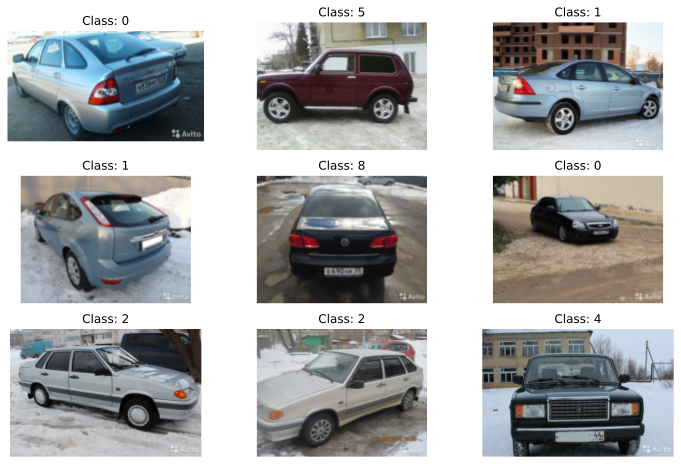

In [12]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12, 8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(f'data/train/{random_image_cat[index]}/{path}')
    plt.subplot(3, 3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')

plt.show()

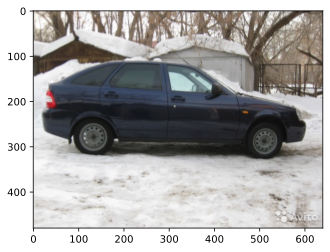

(640, 480)

In [13]:
image = PIL.Image.open('data/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

## Подготовка данных
### Аугментация данных

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=VAL_SPLIT,  # set validation split
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.7, 1],
    zoom_range=0.1,
    channel_shift_range=1.0)

test_datagen = ImageDataGenerator(rescale=1. / 255)

### Генерация данных

In [15]:
# Завернем наши данные в генератор:
train_generator = train_datagen.flow_from_directory(
    'data/train/',      # директория где расположены папки с картинками
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training')  # set as training data

test_generator = train_datagen.flow_from_directory(
    'data/train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation')  # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory='data/test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


Посмотрим результат

Пример картинок из train_generator


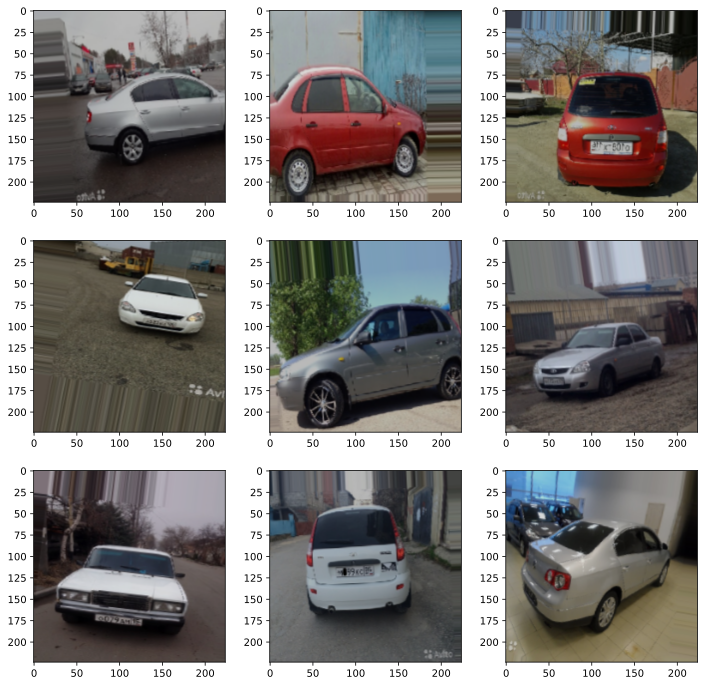

In [16]:
from skimage import io
 
def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()
 
x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,12))
 
for i in range(0,9):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

## Построение модели
### Загружаем предобученную сеть Xception

In [17]:
base_model = Xception(weights='imagenet',
                      include_top=False, input_shape=input_shape)

Замораживаем веса

In [18]:
# first: train only the top layers (which were randomly initialized)
base_model.trainable = False

Строим модель

In [18]:
# Устанавливаем новую "голову" (head)
x = base_model.output

# x = BatchNormalization()(x)
# x = Dropout(0.2)(x)

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)

# x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

## Обучение модели
Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [19]:
checkpoint = ModelCheckpoint('best_model_{}.hdf5'.format(
    part), monitor=['val_accuracy'], verbose=1, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

### Обучаем

In [21]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Epoch 1/10
414/414 [==============================] - 277s 656ms/step - loss: 1.7168 - accuracy: 0.3757 - val_loss: 1.3484 - val_accuracy: 0.5032

Epoch 00001: saving model to best_model_part_3.hdf5
Epoch 2/10
414/414 [==============================] - 280s 677ms/step - loss: 1.2588 - accuracy: 0.5374 - val_loss: 1.1940 - val_accuracy: 0.5569

Epoch 00002: saving model to best_model_part_3.hdf5
Epoch 3/10
414/414 [==============================] - 265s 639ms/step - loss: 1.1964 - accuracy: 0.5603 - val_loss: 1.1721 - val_accuracy: 0.5784

Epoch 00003: saving model to best_model_part_3.hdf5
Epoch 4/10
414/414 [==============================] - 264s 639ms/step - loss: 1.1313 - accuracy: 0.5943 - val_loss: 1.1111 - val_accuracy: 0.5904

Epoch 00004: saving model to best_model_part_3.hdf5
Epoch 5/10
414/414 [==============================] - 266s 641ms/step - loss: 1.0848 - accuracy: 0.6021 - val_loss: 1.0396 - val_accuracy: 0.6196

Epoch 00005: saving model to best_model_part_3.hdf5
Epoch

In [22]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('model_last_{}.hdf5'.format(part))
model.load_weights('best_model_{}.hdf5'.format(part))

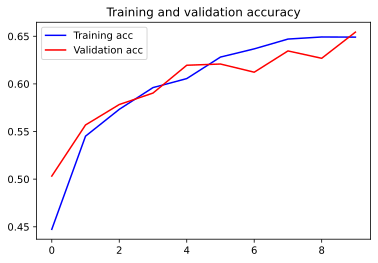

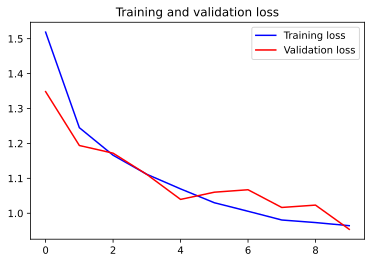

In [23]:
# Графики
make_graf(history)

Посмотрим сколько слоев в имиджнет модели

In [24]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  132


Размораживаем имиджнет-модель частично (44 слоя размораживаем, 88 оставляем замороженными)

In [25]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 88

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Уменьшаем learning rate

In [26]:
LR=0.0005
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

Увеличиваем колиечество эпох обучения, т. к. уменьшили learnig rate

In [27]:
EPOCHS = 15
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Epoch 1/15
414/414 [==============================] - 280s 665ms/step - loss: 0.8944 - accuracy: 0.6911 - val_loss: 0.5639 - val_accuracy: 0.8141

Epoch 00001: saving model to best_model_part_3.hdf5
Epoch 2/15
414/414 [==============================] - 279s 674ms/step - loss: 0.3739 - accuracy: 0.8647 - val_loss: 0.3463 - val_accuracy: 0.8742

Epoch 00002: saving model to best_model_part_3.hdf5
Epoch 3/15
414/414 [==============================] - 282s 680ms/step - loss: 0.2654 - accuracy: 0.9040 - val_loss: 0.3256 - val_accuracy: 0.8897

Epoch 00003: saving model to best_model_part_3.hdf5
Epoch 4/15
414/414 [==============================] - 293s 707ms/step - loss: 0.2290 - accuracy: 0.9135 - val_loss: 0.3130 - val_accuracy: 0.8944

Epoch 00004: saving model to best_model_part_3.hdf5
Epoch 5/15
414/414 [==============================] - 289s 699ms/step - loss: 0.1954 - accuracy: 0.9274 - val_loss: 0.3238 - val_accuracy: 0.8957

Epoch 00005: saving model to best_model_part_3.hdf5
Epoch

In [28]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('model_last_{}.hdf5'.format(part))
model.load_weights('best_model_{}.hdf5'.format(part))

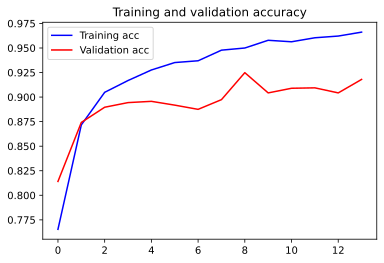

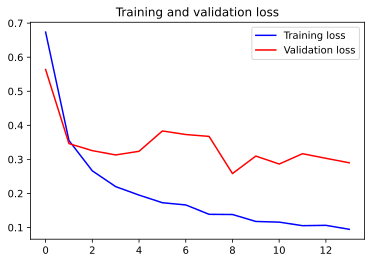

In [29]:
# Графики
make_graf(history)

Еще размораживаем имиджнет-модель частично (44 слоя размораживаем, 44 оставляем замороженными)

In [30]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 44

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Еще уменьшаем learning rate

In [31]:
LR=0.0001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

Еще увеличиваем колиечество эпох обучения

In [32]:
EPOCHS = 20
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Epoch 1/20
414/414 [==============================] - 319s 757ms/step - loss: 0.0868 - accuracy: 0.9676 - val_loss: 0.2546 - val_accuracy: 0.9279

Epoch 00001: saving model to best_model_part_3.hdf5
Epoch 2/20
414/414 [==============================] - 324s 783ms/step - loss: 0.0521 - accuracy: 0.9810 - val_loss: 0.2754 - val_accuracy: 0.9309

Epoch 00002: saving model to best_model_part_3.hdf5
Epoch 3/20
414/414 [==============================] - 315s 760ms/step - loss: 0.0445 - accuracy: 0.9837 - val_loss: 0.2683 - val_accuracy: 0.9253

Epoch 00003: saving model to best_model_part_3.hdf5
Epoch 4/20
414/414 [==============================] - 306s 739ms/step - loss: 0.0385 - accuracy: 0.9848 - val_loss: 0.2903 - val_accuracy: 0.9347

Epoch 00004: saving model to best_model_part_3.hdf5
Epoch 5/20
414/414 [==============================] - 298s 718ms/step - loss: 0.0279 - accuracy: 0.9892 - val_loss: 0.3587 - val_accuracy: 0.9210

Epoch 00005: saving model to best_model_part_3.hdf5
Epoch

In [33]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('model_last_{}.hdf5'.format(part))
model.load_weights('best_model_{}.hdf5'.format(part))

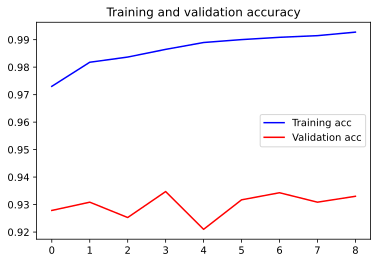

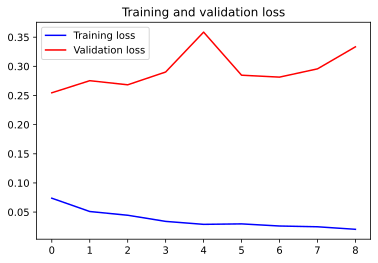

In [34]:
# Графики
make_graf(history)

Окончательно размораживаем имиджнет-модель

In [35]:
base_model.trainable = True

Еще уменьшаем learning rate

In [20]:
LR=0.00005
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

Еще увеличиваем колиечество эпох обучения

In [42]:
EPOCHS = 25
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Epoch 1/25
827/827 [==============================] - 500s 603ms/step - loss: 0.0381 - accuracy: 0.9872 - val_loss: 0.2521 - val_accuracy: 0.9395

Epoch 00001: saving model to best_model_part_3.hdf5
Epoch 2/25
827/827 [==============================] - 518s 626ms/step - loss: 0.0291 - accuracy: 0.9907 - val_loss: 0.2645 - val_accuracy: 0.9377

Epoch 00002: saving model to best_model_part_3.hdf5
Epoch 3/25
827/827 [==============================] - 525s 634ms/step - loss: 0.0270 - accuracy: 0.9904 - val_loss: 0.2770 - val_accuracy: 0.9386

Epoch 00003: saving model to best_model_part_3.hdf5
Epoch 4/25
827/827 [==============================] - 527s 637ms/step - loss: 0.0236 - accuracy: 0.9930 - val_loss: 0.2776 - val_accuracy: 0.9347

Epoch 00004: saving model to best_model_part_3.hdf5
Epoch 5/25
827/827 [==============================] - 509s 615ms/step - loss: 0.0241 - accuracy: 0.9924 - val_loss: 0.2797 - val_accuracy: 0.9390

Epoch 00005: saving model to best_model_part_3.hdf5
Epoch

In [43]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('model_last_{}.hdf5'.format(part))
model.load_weights('best_model_{}.hdf5'.format(part))

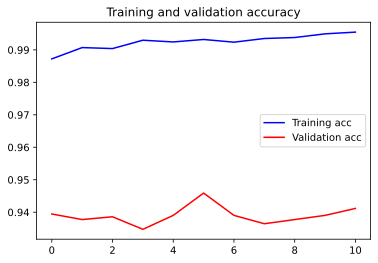

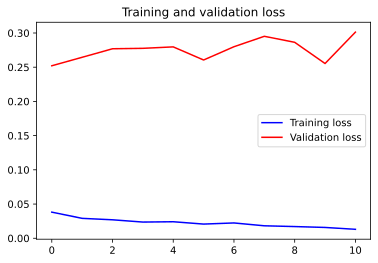

In [44]:
# Графики
make_graf(history)

### Оценим метрику

In [45]:
scores = model.evaluate_generator(
    test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

146/146 [==============================] - 42s 288ms/step - loss: 0.3041 - accuracy: 0.9365
Accuracy: 93.65%


## Предсказание на тестовых данных

In [46]:
test_sub_generator.samples

6675

In [47]:
test_sub_generator.reset()
predictions = model.predict_generator(
    test_sub_generator, steps=len(test_sub_generator), verbose=1)
predictions = np.argmax(predictions, axis=-1)  # multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v, k) for k, v in label_map.items())  # flip k,v
predictions = [label_map[k] for k in predictions]

418/418 [==============================] - 66s 156ms/step


In [48]:
filenames_with_dir = test_sub_generator.filenames
submission = pd.DataFrame(
    {'Id': filenames_with_dir, 'Category': predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/', '')
submission.to_csv('submission_{}.csv'.format(part), index=False)
print('Save submit')

Save submit


In [49]:
submission.head()

,Id,Category
0,305108.jpg,2
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,9


### Вывод по данной части работы:
- Метрика на тесте: 93.65%
- Метрика на Kaggle: 95.101%

**Предварительные выводы:**
- По аугментации: Модель переобучается меньше. Метрика подросла. Идем в правильном направлении.
- По нормализации: Существенных улучшений пока не замечено. Попробуем поэкспериментировать в дальнейшем.